In [1]:
import pandas as pd
import numpy as np
import json
import random

from tqdm import tqdm


Arquivo csv adaptado para diminuir trabalho com tratamento de dados

In [2]:
url = "https://raw.githubusercontent.com/LucasAzvd/teoria-da-decis-o/main/data/i5x25.csv?token=AI4MMZ7EIWXSKHPQXONNAFDBUO2SO"
df = pd.read_csv(url)
df.head(2)

,tarefa,maq_1,maq_2,maq_3,maq_4,maq_5,peso,due_date
0,1,2,1,4,7,8,8,6
1,2,8,3,2,1,5,5,6


# Funções objetivo

## Min F1(x)

\begin{equation}
minf_{1}(x)= C_{max} = max\left (\sum_{j=1}^{N}\sum_{k=1}^{N} t_{ij}x_{ijk}  \right )\\
i\epsilon\left\{ i,...,M \right \}
\end{equation}

Essa função nos trás o tempo de execução máximo de uma máquina, somando todas as tarefas que foram executadas na mesma.   
Seu retorno é representado pelo maior tempo de execução das máquinas e sua minimização 

In [3]:
def min_f1(df_alocacao: pd.DataFrame, tempo_execucao_maquinas_anterior: int) -> dict:
    """Minimizar o makespan, calculando o tempo de execução em todas as máquinas 
            e retornando a que mais demora
    Args
        df_alocacao[pd.DataFrame]: Dataframe com a alocação das máquinas
        tempo_anterior[int]: Tempo anterior de execução das atividades
    Returns:
        bool : Booleano validando se aconteceu ou não uma otimização
        int : O maior tempo de execução das máquinas
    """

    tempo_maximo_atual = max(df_alocacao.iloc[:, 1:6].sum())
    
    if tempo_maximo_atual < tempo_execucao_maquinas_anterior:
        return tempo_maximo_atual
    return tempo_execucao_maquinas_anterior

## Min F2(x)

\begin{equation}
minf_{2}(x)= \sum_{j=1}^{N} w_{j}t_{j}
\end{equation}

Se refere a soma ponderada dos atrasos que ocorreram com a penalidade $W_{j}$.

In [4]:
def min_f2(duodate: int, tij: int, penalidade_anterior: int, penalidade: int) -> dict:
    penalidade = 0
    if tij > duodate:
        penalidade = (tij - duodate)*peso

    if penalidade < penalidade_anterior:
        return True, penalidade
    return False, tempo_anterior


## Restrições

Iremos implementar as seguintes restrições na função abaixo:  
`restricao_tarefas_maquinas`
\begin{equation}
 \sum_{i=1}^{M}\sum_{k=1}^{N+1} x_{ijk} = 1,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

`restricao_tempo_máximo`
\begin{equation}
C_{max}\geq  \sum_{i=1}^{M}\sum_{k=1}^{N+1} t_{ij}x_{ijk},\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de validar que um máquina pode ficar sem nenhuma tarefa atribuída.
\begin{equation}
\sum_{k=1}^{N} x_{i0k}\leq 1,\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de verificação de finalização de tarefas antes da atribuição a uma máquina.
\begin{equation}
\sum_{j=1,j\neq h}^{N+1} x_{ijh} - \sum_{k=1,k\neq h}^{N+1} x_{ihk} = 0,\forall h\epsilon \left \{ 1,...,N \right \}e\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata se a tarefa está exutando uma tarefa ou não.
\begin{equation}
C_{ik}\geqslant C_{ij} - L + \left ( t_{ij}+L \right )x_{ijk},\forall \text{j e k}\epsilon \left \{ 1,..,N \right \}
\end{equation}

`restricao_tempo_atraso`
\begin{equation}
T_{j}\geq C_{j}-d,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

Caso alguma restrição seja violada, retornamos **True**.

In [5]:
def restricao_tarefas_maquinas(df_alocacao: pd.DataFrame):
    """Cada tarefa deverá ir para uma máquina obrigatoriamente, garantindo que todas as tarefas sejam executadas.
    Nela verificamos de existe alguma linha vazia no nosso dataframe de linhas de execução, que representaria uma tarefa sem alocar.
    Também verificamos se as tarefas são alocadas apenas para uma máquina.
    """
    soma_linhas_dataframe = df_alocacao.iloc[:,1:6].nunique(axis=1)
    for i in soma_linhas_dataframe:
        if i != 2: # Restricao violada
            print("Restrito: restricao_tarefas_maquinas")
            return True 

    return False

In [6]:
def restricao_tempo_maximo(df_alocacao: int, tempo_execucao_maquinas: list):
    """Nesta restrição garantimos que o tempo máximo de execução seja respeitado.
    """
    for tempo_exec in np.array(df_alocacao.iloc[:,1:6].sum()):
        if tempo_exec > tempo_execucao_maquinas: # Viola restrição
            print("Restrito: restricao_tempo_maximo")
            return True
        else:
            return False

In [7]:
def restricao_tempo_atraso(df_alocacao: True):
    """Restrição referente ao tempo de atraso, ela delimita que o tempo de execução
    da tarefa tem que ser limitado pelo tempo d definido."""
    df_aux = df_alocacao.copy()
    df_aux['tempo_atraso'] = df_aux['due_date'] - df_alocacao.iloc[:, 1:6].max(axis=1)
    
    df_aux['restricao_atraso'] = df_aux['tempo_atraso'] - df_aux['due_date'] + df_alocacao.iloc[:, 1:6].max(axis=1)
    if sum(df_aux['restricao_atraso']):
        print("Restrito: restricao_tempo_atraso")
        return True
    else:
        return False

## Estrutura de vizinhança

1.   Shift
2.   Swtich
3.   Swap
4.   Two-Shift
5.   Task-Move


In [8]:
def swap(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    quant_maquinas = 5
    tarefa_swap_1 = random.randint(1,quant_tarefas)
    if tarefa_swap_1 == quant_tarefas:
        tarefa_swap_2 = tarefa_swap_1 - 1
    else:
        tarefa_swap_2 = tarefa_swap_1 + 1

    tarefa_swap_1_list = df_alocacao[df_alocacao['tarefa'] == tarefa_swap_1].iloc[:, 1:6].values[0].copy()
    tarefa_swap_2_list = df_alocacao[df_alocacao['tarefa'] == tarefa_swap_2].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(tarefa_swap_1_list)):
        if tarefa_swap_1_list[i] > 0:
            maq_1 = i+1
            df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_1,f'maq_{i+1}'] = 0

    for i in range(0, len(tarefa_swap_2_list)):
        if tarefa_swap_2_list[i] > 0:
            maq_2 = i+1
            df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_2, f'maq_{maq_2}'] = 0

    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_1, f'maq_{maq_2}'] = df[df["tarefa"] == tarefa_swap_1][f'maq_{maq_2}']
    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_2, f'maq_{maq_1}'] = df[df["tarefa"] == tarefa_swap_2][f'maq_{maq_1}']

    return df_alocacao

In [9]:
def task_move(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    task_to_move = random.randint(1,quant_tarefas)

    list_tasks = df_alocacao[df_alocacao['tarefa'] == task_to_move].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(list_tasks)):
        if list_tasks[i] > 0:
            maq = i+1
            df_alocacao.loc[df_alocacao["tarefa"] == task_to_move, f'maq_{maq}'] = 0
            if maq == 5:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move, f'maq_{maq-1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq-1}']
            else:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move, f'maq_{maq+1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq+1}']
            break

    return df_alocacao

In [10]:
def estruturas(df_alocacao, df, k):
    if k==1:
        df_alocacao_new = swap(df_alocacao, df)
    else:
        df_alocacao_new = task_move(df_alocacao, df)
    return df_alocacao_new

## Variáveis

In [11]:
quant_maq = 5
quant_tarefas = df.shape[0]

In [12]:
df_alocacao = df.copy()
df_alocacao['maq_1'] = 0
df_alocacao['maq_2'] = 0
df_alocacao['maq_3'] = 0
df_alocacao['maq_4'] = 0
df_alocacao['maq_5'] = 0

Alocando as tarefas nas máquinas aleatóriamente

In [13]:
for i in range(0, quant_tarefas):
    maq_aloc = random.randint(1,quant_maq)
    while (df_alocacao[f'maq_{maq_aloc}'].nunique()-1)  == 5:
        maq_aloc = random.randint(1,quant_maq)

    # Pegando tarefa i e atribuindo o valor dela a maquina referente
    df_alocacao.iloc[i][f'maq_{maq_aloc}'] = df[df['tarefa'] == i+1][f'maq_{maq_aloc}'].values[0]


Calculando a penalidade inicial da nossa alocação

In [14]:
df_alocacao['penalidade'] = 0
df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']

# Execução do nosso algoritmo de otimização para F1

In [15]:
n_execucoes = 100
list_tempos = []

tempo_maximo_inicial = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())
list_tempos.append(tempo_maximo_inicial)

k = 1
for _ in range(0, n_execucoes):
    tempo_maximo_execucao = tempo_maximo_inicial
    df_alocacao_new = df_alocacao.copy()
    df_alocacao_new = estruturas(df_alocacao, df, k)
    restricao_1 = restricao_tarefas_maquinas(df_alocacao_new)
    restricao_2 = restricao_tempo_maximo(df_alocacao_new, tempo_maximo_execucao)
    restricao_3 = restricao_tempo_atraso(df_alocacao_new)
    if restricao_1 or restricao_2 or restricao_3:
        # Se alguma restrição verdadeira, adicionamos os valores antigos a lista
        list_tempos.append(tempo_maximo_inicial)
    else:
        tempo_maximo_execucao = min_f1(df_alocacao_new, tempo_maximo_inicial)
        
        if tempo_maximo_execucao < tempo_maximo_inicial:
            tempo_maximo_inicial = tempo_maximo_execucao  
            df_alocacao = df_alocacao_new.copy()

        list_tempos.append(tempo_maximo_inicial)
            

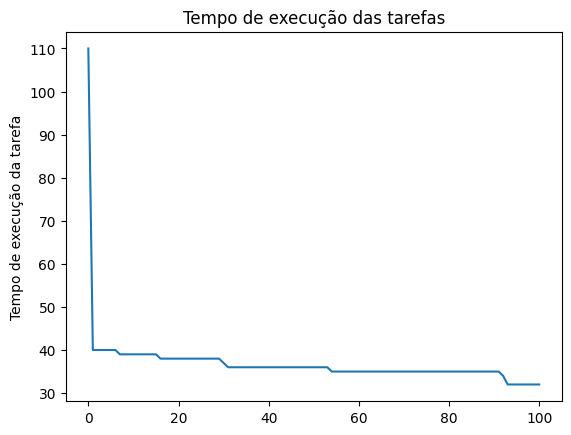

In [17]:
import matplotlib.pyplot as plt

plt.plot(list_tempos)
plt.title("Tempo de execução das tarefas")
plt.ylabel("Tempo de execução da tarefa")
plt.show()

# Execução algoritmo para F2

In [ ]:
n_execucoes = 10
n = 0
list_tempos = []
list_penalidades = []

tempo_maximo_inicial = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())
penalidade_maximo = sum(df_alocacao['penalidade'])

list_tempos.append(tempo_maximo_inicial)
list_penalidades.append(penalidade_maximo)

while n < n_execucoes:
    tempo_maximo_execucao = tempo_maximo_inicial
    penalidade_execucao = penalidade_maximo
    k = 1
    df_alocacao = estruturas(df_alocacao, df, k)
    restricao_1 = restricao_tarefas_maquinas(df_alocacao)
    restricao_2 = restricao_tempo_maximo(df_alocacao, tempo_maximo_execucao)
    restricao_3 = restricao_tempo_atraso(df_alocacao)
    if restricao_1 or restricao_2 or restricao_3:
        # Se alguma restrição verdadeira, adicionamos os valores antigos a lista
        list_tempos.append(tempo_maximo_inicial)
        list_penalidades.append(penalidade_maximo)
    else:
        min_f2(df_alocacao, tempo_maximo_inicial)
        
    n+=1 